(a) Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics.
uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data
randomly as the training set.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
dataset = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
xDataset = dataset.iloc[:, :22]
yDataset = dataset.iloc[:, 22:-1]
xTrain, xTest, yTrain, yTest = train_test_split(xDataset, yDataset, test_size=0.3, random_state=233)
yTrain

,Family,Genus,Species
7164,Hylidae,Scinax,ScinaxRuber
232,Leptodactylidae,Adenomera,AdenomeraAndre
913,Dendrobatidae,Ameerega,Ameeregatrivittata
3871,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
5172,Hylidae,Hypsiboas,HypsiboasCinerascens
...,...,...,...
1155,Dendrobatidae,Ameerega,Ameeregatrivittata
6140,Hylidae,Hypsiboas,HypsiboasCordobae
2417,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
3879,Leptodactylidae,Adenomera,AdenomeraHylaedactylus


(b) Each instance has three labels: Families, Genus, and Species. Each of the labels
has multiple classes. We wish to solve a multi-class and multi-label problem.
One of the most important approaches to multi-label classification is to train a
classifier for each label (binary relevance). We first try this approach:

i. Research exact match and hamming score/ loss methods for evaluating multilabel classification and use them in evaluating the classifiers in this problem.

# 1. Exact match: detects whether all classes are exactly matched with the label. 
# 2. Hamming score: the fraction of labels that are correctly predicted. 
# 3. Hamming loss: the fraction of labels that are incorrectly predicted.

ii. Train a SVM for each of the labels, using Gaussian kernels and one versus
all classifiers. Determine the weight of the SVM penalty and the width of
the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try
to solve the problem with both standardized 2 and raw attributes and report
the results.

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math
import warnings
from joblib import parallel_backend
warnings.filterwarnings('ignore')


y1Train = yTrain['Family']
y2Train = yTrain['Genus']
y3Train = yTrain['Species']
y1Test = yTest['Family']
y2Test = yTest['Genus']
y3Test = yTest['Species']
with parallel_backend('threading', n_jobs=-1):
    cRange = [10**c for c in np.arange(-4, 4, dtype=float)]
    gammaRange = np.arange(0.1, 2.1, 0.1)
    svcModel = SVC(kernel='rbf', random_state=233, max_iter = 1000)
    # get best parameters for each y(class)
    parameters = {'C':cRange, 'gamma':gammaRange}
    clf1 = GridSearchCV(svcModel, parameters, cv=10).fit(xTrain, y1Train)
    clf2 = GridSearchCV(svcModel, parameters, cv=10).fit(xTrain, y2Train)
    clf3 = GridSearchCV(svcModel, parameters, cv=10).fit(xTrain, y3Train)

    c1, gamma1 = clf1.best_params_['C'], clf1.best_params_['gamma']
    c2, gamma2 = clf2.best_params_['C'], clf2.best_params_['gamma']
    c3, gamma3 = clf3.best_params_['C'], clf3.best_params_['gamma']
    print('----best cost and gamma got by cross validation-----')
    print('c1', c1, 'gamma1', gamma1)
    print('c2', c2, 'gamma2', gamma2)
    print('c3', c3, 'gamma3', gamma3)

----best cost and gamma got by cross validation-----
c1 10.0 gamma1 2.0
c2 10.0 gamma2 0.8
c3 10.0 gamma3 1.9000000000000001


In [3]:
# calculate hamming socre/ excat match, yPredict and yTrue are DataFrame
def countScore(yPredict, yTrue):
    totalInstance1 = yPredict.shape[0] * yPredict.shape[1]
    totalInstance2 = yPredict.shape[0]
    correct_1 = 0
    correct_2 = 0
    for i, r in enumerate(yPredict.iterrows()):
        if yPredict.iloc[i].tolist() == yTrue.iloc[i].tolist():
            correct_2 += 1
        for j in range(yPredict.shape[1]):
            if yPredict.iloc[i].tolist()[j] == yTrue.iloc[i].tolist()[j]:
                correct_1 += 1
    return correct_1/totalInstance1, correct_2/totalInstance2

# using the best parameters to build model and train
svcModel1 = SVC(C=c1, gamma=gamma1,kernel='rbf', random_state=233).fit(xTrain, y1Train)
svcModel2 = SVC(C=c2, gamma=gamma2,kernel='rbf', random_state=233).fit(xTrain, y2Train)
svcModel3 = SVC(C=c3, gamma=gamma3,kernel='rbf', random_state=233).fit(xTrain, y3Train)

# predict the class
y1Predict = pd.DataFrame(svcModel1.predict(xTest))
y2Predict = pd.DataFrame(svcModel2.predict(xTest))
y3Predict = pd.DataFrame(svcModel3.predict(xTest))
yPredict = pd.concat([y1Predict, y2Predict, y3Predict], axis=1)
svcModelHammingScore, exactMatch = countScore(yPredict, yTest)
# svcModelHammingScore = sklearn.metrics.hamming_loss(yPredict, yTest)
print('Gaussian kernels')
print('Exact Match:', exactMatch)
print('Hamming Score:', svcModelHammingScore)
print('Hamming Loss:', 1-svcModelHammingScore)

Gaussian kernels
Exact Match: 0.9865678554886521
Hamming Score: 0.9915084143893778
Hamming Loss: 0.008491585610622243


iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4
the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [4]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing

# standardize train and test data
scaler = preprocessing.StandardScaler()
standXTrain = scaler.fit_transform(xTrain)
standXTest = scaler.fit_transform(xTest)

# cross validation to get best cost
parameters = {'C':cRange}
svcL1Model = LinearSVC(penalty='l1', dual=False, random_state=233)
with parallel_backend('threading', n_jobs=-1):
    L1clf1 = GridSearchCV(svcL1Model, parameters, cv=10).fit(standXTrain, y1Train)
    L1clf2 = GridSearchCV(svcL1Model, parameters, cv=10).fit(standXTrain, y2Train)
    L1clf3 = GridSearchCV(svcL1Model, parameters, cv=10).fit(standXTrain, y3Train)

# using the best parameters to build model and train
c1 = L1clf1.best_params_['C']
c2 = L1clf2.best_params_['C']
c3 = L1clf3.best_params_['C']
svcL1Model1 = LinearSVC(penalty='l1', C=c1, dual=False, random_state=233).fit(standXTrain, y1Train)
svcL1Model2 = LinearSVC(penalty='l1', C=c2, dual=False, random_state=233).fit(standXTrain, y2Train)
svcL1Model3 = LinearSVC(penalty='l1', C=c3, dual=False, random_state=233).fit(standXTrain, y3Train)

# predict the class
y1Predict = pd.DataFrame(svcL1Model1.predict(standXTest))
y2Predict = pd.DataFrame(svcL1Model2.predict(standXTest))
y3Predict = pd.DataFrame(svcL1Model3.predict(standXTest))
yPredict = pd.concat([y1Predict, y2Predict, y3Predict], axis=1)

# count metrics
svcModelHammingScore, exactMatch = countScore(yPredict, yTest)
print('L1-penalized SVMs')
print('Exact Match:', exactMatch)
print('Hamming Score:', svcModelHammingScore)
print('Hamming Loss:', 1-svcModelHammingScore)

L1-penalized SVMs
Exact Match: 0.9147753589624826
Hamming Score: 0.9454994596263703
Hamming Loss: 0.054500540373629724


iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy
class imbalance. Report your conclusions about the classifiers you trained.

In [5]:
from imblearn.over_sampling import SMOTE
# smote dataset
sm = SMOTE()
smoteTrainx1, smoteTrainy1 = sm.fit_resample(standXTrain, y1Train)
smoteTrainx2, smoteTrainy2 = sm.fit_resample(standXTrain, y2Train)
smoteTrainx3, smoteTrainy3 = sm.fit_resample(standXTrain, y3Train)

# cross validation to get best cost
parameters = {'C':cRange}
svcL1Model = LinearSVC(penalty='l1', dual=False, random_state=233)
with parallel_backend('threading', n_jobs=-1):
    smoteL1clf1 = GridSearchCV(svcL1Model, parameters, cv=10).fit(smoteTrainx1, smoteTrainy1)
    smoteL1clf2 = GridSearchCV(svcL1Model, parameters, cv=10).fit(smoteTrainx2, smoteTrainy2)
    smoteL1clf3 = GridSearchCV(svcL1Model, parameters, cv=10).fit(smoteTrainx3, smoteTrainy3)

# using the best parameters to build model and train
c1 = smoteL1clf1.best_params_['C']
c2 = smoteL1clf2.best_params_['C']
c3 = smoteL1clf3.best_params_['C']
smoteSvcL1Model1 = LinearSVC(penalty='l1', C=c1, dual=False, random_state=233).fit(smoteTrainx1, smoteTrainy1)
smoteSvcL1Model2 = LinearSVC(penalty='l1', C=c2, dual=False, random_state=233).fit(smoteTrainx2, smoteTrainy2)
smoteSvcL1Model3 = LinearSVC(penalty='l1', C=c3, dual=False, random_state=233).fit(smoteTrainx3, smoteTrainy3)

# predict the class
smoteY1Predict = pd.DataFrame(smoteSvcL1Model1.predict(standXTest))
smoteY2Predict = pd.DataFrame(smoteSvcL1Model2.predict(standXTest))
smoteY3Predict = pd.DataFrame(smoteSvcL1Model3.predict(standXTest))
smoteYPredict = pd.concat([smoteY1Predict, smoteY2Predict, smoteY3Predict], axis=1)

# count metrics
svcModelHammingScore, exactMatch = countScore(smoteYPredict, yTest)
print('Smote L1-penalized SVMs')
print('Exact Match:', exactMatch)
print('Hamming Score:', svcModelHammingScore)
print('Hamming Loss:', 1-svcModelHammingScore)

Smote L1-penalized SVMs
Exact Match: 0.8610467809170912
Hamming Score: 0.9286706808707735
Hamming Loss: 0.07132931912922647


# The metrics we count in 3 classifers: Gaussian kernel SVM better than l1-penalized SVM better than SMOTE SVM

2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

Monte-Carlo Simulation: Perform the following procedures 50 times, and report
the average and standard deviation of the 50 Hamming Distances that you calculate.

(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split
the data into train and test, as we are not performing supervised learning in this
exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods
provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any
other method you know.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

bestK = 1
maxScore = 0
# Monte-Carlo Simulation
for i in tqdm(range(50)):
    for k in range(2, 51):
        kmeansModel = KMeans(n_clusters=k).fit(xDataset)
        labels = kmeansModel.labels_
        score = silhouette_score(xDataset, labels)
        if score > maxScore:
            maxScore = score
            bestK = k
print('best k is:', bestK)
print('max Silhouettes score is:', maxScore)

100%|██████████| 50/50 [42:54<00:00, 51.49s/it]

best k is: 4
max Silhouettes score is: 0.38525558106940394


(b) In each cluster, determine which family is the majority by reading the true labels.
Repeat for genus and species.

In [7]:
# note: this process will be repeated in (c) to achieve Monte-Carlo Simulation
kmeans = KMeans(n_clusters=bestK, random_state=233).fit(xDataset)
labels = kmeans.labels_

y1Dataset = yDataset['Family']
y2Dataset = yDataset['Genus']
y3Dataset = yDataset['Species']
clusterIndex = {}
labels = pd.Series(labels)
for i in range(bestK):
    clusterIndex[i] = list(labels.index[labels==i])
    majorityInFamily = y1Dataset[clusterIndex[i]].value_counts(sort=True, ascending=False).index[0]
    majorityInGenus = y2Dataset[clusterIndex[i]].value_counts(sort=True, ascending=False).index[0]
    majorityInSpecies = y3Dataset[clusterIndex[i]].value_counts(sort=True, ascending=False).index[0]
    
    print('Cluster', i, ' majority in Family:', majorityInFamily)
    print('Cluster', i, ' majority in Genus:', majorityInGenus)
    print('Cluster', i, ' majority in Species:', majorityInSpecies,'\n')

Cluster 0  majority in Family: Dendrobatidae
Cluster 0  majority in Genus: Ameerega
Cluster 0  majority in Species: Ameeregatrivittata 

Cluster 1  majority in Family: Leptodactylidae
Cluster 1  majority in Genus: Adenomera
Cluster 1  majority in Species: AdenomeraHylaedactylus 

Cluster 2  majority in Family: Hylidae
Cluster 2  majority in Genus: Hypsiboas
Cluster 2  majority in Species: HypsiboasCordobae 

Cluster 3  majority in Family: Hylidae
Cluster 3  majority in Genus: Hypsiboas
Cluster 3  majority in Species: HypsiboasCinerascens 



(c) Now for each cluster you have a majority label triplet (family, genus, species).
Calculate the average Hamming distance, Hamming score, and Hamming loss5
between the true labels and the labels assigned by clusters.

In [8]:
def getHammingDistance(yPredict, yTrue):
    yPredict = yPredict.reset_index().iloc[:,1:]
    yTrue = yTrue.reset_index().iloc[:,1:]
    totalInstance = yPredict.shape[0] * yPredict.shape[1]
    correct = 0
    for i, row in enumerate(yPredict.iterrows()):
        for j in range(yPredict.shape[1]):
            if yPredict.iloc[i].tolist()[j] == yTrue.iloc[i].tolist()[j]:
                correct += 1
        # if yPredict.loc[i].tolist() == yTrue.loc[i].tolist():
        #     correct += 1
    return totalInstance - correct

distances = list()
scores = list()
loss = list()
pd.concat([y1Dataset, y1Dataset, y1Dataset], axis=1)
yDatasetCol = y1Dataset.append(y2Dataset).append(y3Dataset)

# Monte-Carlo Simulation
for i in range(50):
    kmeans = KMeans(n_clusters=bestK).fit(xDataset)
    labels = kmeans.labels_
    
    clusterIndex = dict()
    labels = pd.Series(labels)
    clusterMajority = dict()
    # get each cluster 
    for i in range(bestK):
        clusterIndex[i] = labels.index[labels==i].tolist()
        majorityInFamily = y1Dataset[clusterIndex[i]].value_counts().index[0]
        majorityInGenus = y2Dataset[clusterIndex[i]].value_counts().index[0]
        majorityInSpecies = y3Dataset[clusterIndex[i]].value_counts().index[0]
        clusterMajority[i] = [majorityInFamily, majorityInGenus, majorityInSpecies]
    
    yLabels = pd.DataFrame(columns=yDataset.columns, index=yDataset.index)
    for cluster in range(bestK):
        for i in clusterIndex[cluster]:
            yLabels.loc[i] = clusterMajority[cluster]
    
    hammingDistance = getHammingDistance(yLabels, yDataset)
    hammingScore, _ = countScore(yLabels, yDataset)
    hammingLoss = 1 - hammingScore
    
    distances.append(hammingDistance)
    scores.append(hammingScore)
    loss.append(hammingLoss)

# print(hammingDistance, hammingScore, hammingLoss)
print('Avg Hamming Disance', round(np.array(distances).mean(), 5))
print('Std Hamming Disance', round(np.array(distances).std(), 5))
print()
print('Avg Hamming Score', round(np.array(scores).mean(), 5))
print('Std Hamming Score', round(np.array(scores).std(), 5))
print()
print('Avg Hamming Loss', round(np.array(loss).mean(), 5))
print('Std Hamming Loss', round(np.array(loss).std(), 5))

Avg Hamming Disance 4859.42
Std Hamming Disance 207.99395

Avg Hamming Score 0.77487
Std Hamming Score 0.00964

Avg Hamming Loss 0.22513
Std Hamming Loss 0.00964


3. ISLR 12.6.2

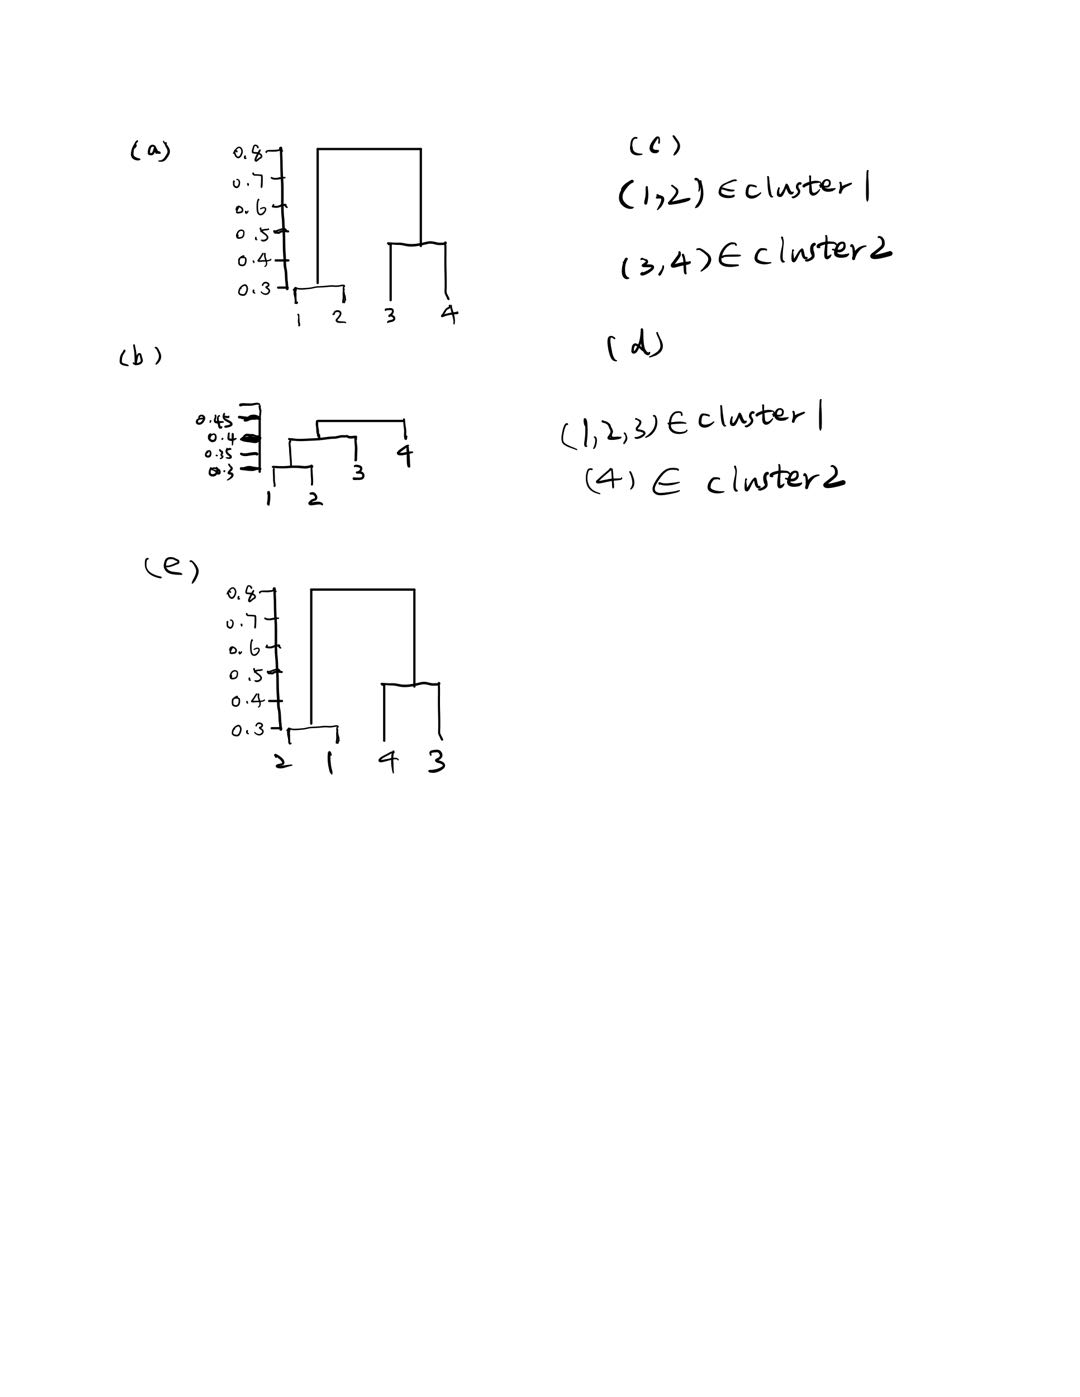

In [9]:
from IPython.display import Image
Image(filename='12.6.2.png')